# Supervised Contrastive Learning

## Introduction

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

import numpy as np
from tqdm.notebook import trange

torch.manual_seed(42)

## Prepare the data

In [2]:
transform = transforms.ToTensor()

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('# trainset :', len(trainset))
print('# testset  :', len(testset))

# trainset : 50000
# testset  : 10000


## Using image data augmentation

In [4]:
# https://github.com/Spijkervet/SimCLR/blob/cd85c4366d2e6ac1b0a16798b76ac0a2c8a94e58/simclr/modules/transformations/simclr.py#L4

class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, size):
        
        self.alpha = (-0.2 - 0.2) * torch.rand(1) + 0.2 # -20% ~ + 20% 사이 랜덤 생성
        self.beta = (-0.2 - 0.2) * torch.rand(1) + 0.2
        self.h = int(size[0]*(1+self.alpha))
        self.w = int(size[1]*(1+self.beta))
        self.random_size = (self.h, self.w)
        self.train_transform = torchvision.transforms.Compose(
            [
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # adjusted to CIFAR10
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomRotation(7.2),
                torchvision.transforms.Resize(self.random_size), # random size로 조정
            ]
        )

    def __call__(self, x):
        return self.train_transform(x)

In [5]:
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
from PIL import Image
import matplotlib.pyplot as plt

def plot_aug(im):
    # approximate unnormalization 
    im = im.detach().cpu()
    im[0] = im[0]*0.229 + 0.485
    im[1] = im[1]*0.224 + 0.456
    im[2] = im[2]*0.225 + 0.406
    plt.imshow(np.transpose(im, (1, 2, 0)))
    plt.show()
                             

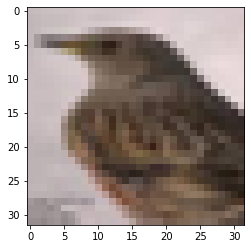

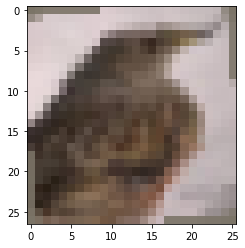

In [6]:
data_augmentation = TransformsSimCLR((32,32))
orig_img = trainset[18][0]

plt.imshow(np.transpose(orig_img, (1,2,0)))
plt.show()

augmented_img = data_augmentation(orig_img)
plot_aug(augmented_img)

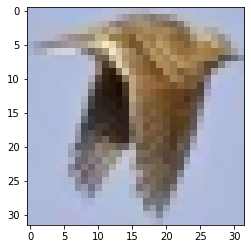

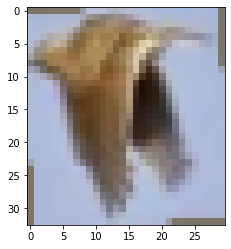

In [7]:
data_augmentation = TransformsSimCLR((32,32))
orig_img = trainset[123][0]

plt.imshow(np.transpose(orig_img, (1,2,0)))
plt.show()

augmented_img = data_augmentation(orig_img)
plot_aug(augmented_img)

## Build the encoder model

The encoder model takes the image as input and turns it into a 2048-dimensional
feature vector.

* 2048 차원의 feature vector 생성
* 기존 ResNet18의 마지막 FC Layer(classifier)를 빼고 encoder를 만듦
* 케라스는 ResNet50 사용하였으나, 메모리/시간 상의 문제로 ResNet18 사용

In [11]:
import torchvision.models as models

class Encoder(nn.Module):
    def __init__(self, resnet_pt, data_augmentation):
        super().__init__()
        # drop last fully connected layer
        self.resnet = nn.Sequential(*list(resnet_pt.children())[:-1]) 
        self.data_augmentation = data_augmentation
        
    def forward(self, x):
        aug_x = self.data_augmentation(x)
        out = self.resnet(aug_x)
        return out

resnet_pt = models.resnet18(pretrained=True)
encoder = Encoder(resnet_pt, data_augmentation)

In [12]:
summary(encoder, (1, 3, 32, 32))

Layer (type:depth-idx)                        Output Shape              Param #
Encoder                                       --                        --
├─Sequential: 1-1                             [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [1, 64, 17, 15]           9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 17, 15]           128
│    └─ReLU: 2-3                              [1, 64, 17, 15]           --
│    └─MaxPool2d: 2-4                         [1, 64, 9, 8]             --
│    └─Sequential: 2-5                        [1, 64, 9, 8]             --
│    │    └─BasicBlock: 3-1                   [1, 64, 9, 8]             73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 9, 8]             73,984
│    └─Sequential: 2-6                        [1, 128, 5, 4]            --
│    │    └─BasicBlock: 3-3                   [1, 128, 5, 4]            230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 5, 4]            295,42

## Build the classification model

The classification model adds a fully-connected layer on top of the encoder,
plus a softmax layer with the target classes.

* 앞의 encoder에 붙일 MLP classifier를 생성

In [13]:
learning_rate = 0.001
# batch_size = 256
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05
num_classes = 10

class Classifier(nn.Module):
    def __init__(self, encoder, dropout_rate, hidden_units, num_classes):
        super().__init__()
        self.encoder = encoder.train()
        self.Dropout_1 = nn.Dropout(dropout_rate)
        self.Dropout_2 = nn.Dropout(dropout_rate)
        self.Linear_1 = nn.Linear(512, hidden_units)
        self.Linear_2 = nn.Linear(hidden_units, num_classes)
        
    def forward(self, x):
        out = self.encoder(x)
        out = out.view(out.size(0), -1)
        out = self.Dropout_1(out)
        out = self.Linear_1(out)
        out = F.relu(out)
        out = self.Dropout_2(out)
        out = self.Linear_2(out)
        return out

## Experiment 1: Train the baseline classification model

In this experiment, a baseline classifier is trained as usual, i.e., `the
encoder and the classifier parts are trained together` as a single model
to minimize the crossentropy loss.

* **[Experiment 1]** 은 encoder와 classifier를 함께 붙여서 CE Loss로 한번에 학습 진행
* **[Experiment 2]** 에서는 encoder를 Contrastive Loss를 활용하여 한번 학습을 시키고, 이후에 classifier를 따로 학습
* classifier는 동일한 것을 사용하여 contrastive loss로의 encoder 학습 여부에 따른 성능 비교

In [14]:
classifier = Classifier(encoder, dropout_rate, hidden_units, num_classes)
summary(classifier, (1, 3, 32, 32))

Layer (type:depth-idx)                             Output Shape              Param #
Classifier                                         --                        --
├─Encoder: 1-1                                     [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 512, 1, 1]            --
│    │    └─Conv2d: 3-1                            [1, 64, 17, 15]           9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 17, 15]           128
│    │    └─ReLU: 3-3                              [1, 64, 17, 15]           --
│    │    └─MaxPool2d: 3-4                         [1, 64, 9, 8]             --
│    │    └─Sequential: 3-5                        [1, 64, 9, 8]             147,968
│    │    └─Sequential: 3-6                        [1, 128, 5, 4]            525,568
│    │    └─Sequential: 3-7                        [1, 256, 3, 2]            2,099,712
│    │    └─Sequential: 3-8                        [1, 512, 2, 1]            8,393,728
│    │ 

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Current device : ', device)

total_step = len(trainloader)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

# Train the model.
print("resnet classifier model training...")

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in trange(num_epochs):
    running_loss = 0
    classifier.train()
    
    train_correct = 0
    train_total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classifier(inputs)  # torch.Size([256, 10])
        predictions = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
        train_total += labels.size(0)
        train_correct += (predictions == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if (i+1)%50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item())) 
            
    train_loss.append(loss)
    train_accuracy = 100 * train_correct / train_total
    train_acc.append(train_accuracy)
    
    valid_correct = 0
    valid_total = 0
    for i, test_data in enumerate(testloader):
        classifier.eval()
        
        test_inputs, test_labels = test_data

        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        test_outputs = classifier(test_inputs)
        val_loss = criterion(test_outputs, test_labels)
        
        test_predictions = torch.argmax(F.softmax(test_outputs, dim=-1), dim=-1)
        valid_total += test_labels.size(0)
        valid_correct += (test_predictions == test_labels).sum().item()
    
    valid_loss.append(val_loss)
    valid_accuracy = 100 * valid_correct / valid_total
    valid_acc.append(valid_accuracy)
    print(f'=> Train Accuracy : {train_accuracy}%  |  Valid Accuracy : {valid_accuracy}%')
    print("==================================================")

print('Finished Training')

inv_history = {'train_loss': train_loss,
               'valid_loss': valid_loss,
               'train_acc': train_acc,
               'valid_acc': valid_acc}

Current device :  cuda
resnet classifier model training...


Epoch [1/50], Step [49/196], Loss: 1.1489
Epoch [1/50], Step [99/196], Loss: 0.8601
Epoch [1/50], Step [149/196], Loss: 1.0026
=> Train Accuracy : 66.102%  |  Valid Accuracy : 71.69%
Epoch [2/50], Step [49/196], Loss: 0.6781
Epoch [2/50], Step [99/196], Loss: 0.7634
Epoch [2/50], Step [149/196], Loss: 0.5819
=> Train Accuracy : 77.5%  |  Valid Accuracy : 75.9%
Epoch [3/50], Step [49/196], Loss: 0.5878
Epoch [3/50], Step [99/196], Loss: 0.5459
Epoch [3/50], Step [149/196], Loss: 0.6590
=> Train Accuracy : 80.54%  |  Valid Accuracy : 76.85%
Epoch [4/50], Step [49/196], Loss: 0.4247
Epoch [4/50], Step [99/196], Loss: 0.5327
Epoch [4/50], Step [149/196], Loss: 0.5291
=> Train Accuracy : 82.954%  |  Valid Accuracy : 77.13%
Epoch [5/50], Step [49/196], Loss: 0.4936
Epoch [5/50], Step [99/196], Loss: 0.5033
Epoch [5/50], Step [149/196], Loss: 0.4827
=> Train Accuracy : 84.378%  |  Valid Accuracy : 79.25%
Epoch [6/50], Step [49/196], Loss: 0.4056
Epoch [6/50], Step [99/196], Loss: 0.4592
Epoch

## Experiment 2: Use supervised contrastive learning

In this experiment, the model is trained in two phases. In the first phase,
`the encoder is pretrained to optimize the supervised contrastive loss`,
described in [Prannay Khosla et al.](https://arxiv.org/abs/2004.11362).

In the second phase, `the classifier is trained using the trained encoder with
its weights freezed`; only the weights of fully-connected layers with the
softmax are optimized.

* **Phase 1**: Encoder + Single Linear projection layer(Contrastive loss 계산을 위한 feature projection 역할) + Contrastive Loss 로 학습
* **Phase 2**: Encoder Freeze 시키고 **[Experiment 1]** 과 동일한 classifier를 붙여서 학습하여 비교

### 1. Supervised contrastive learning loss function

* `torch.eq`

In [29]:
y_true = torch.tensor([1,2,3,4,1,2]) # labels , size : [batch]
print(torch.eq(y_true.unsqueeze(-1), y_true.unsqueeze(-1).T))
y_true = torch.eq(y_true.unsqueeze(-1), y_true.unsqueeze(-1).T).float()
y_true /= torch.sum(y_true, dim=1, keepdim=True)
print(y_true)

tensor([[ True, False, False, False,  True, False],
        [False,  True, False, False, False,  True],
        [False, False,  True, False, False, False],
        [False, False, False,  True, False, False],
        [ True, False, False, False,  True, False],
        [False,  True, False, False, False,  True]])
tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.0000, 0.5000]])


* True 부분에서 유사도 값이 최대가 되어야 함
* Symmetric matrix
* 궁극적 목적 => prediction(logits)에 softmax를 취한 것과 y_true 의 분포가 유사하도록 
> positive pair similarity 크게

In [16]:
# https://github.com/tensorflow/addons/blob/v0.15.0/tensorflow_addons/losses/npairs.py#L23-L73

class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=1):
        super().__init__()
        self.temperature = temperature

    def npairs_loss(self, y_true, y_pred):
        """Computes the npairs loss between `y_true` and `y_pred`.
        Npairs loss expects paired data where a pair is composed of samples from
        the same labels and each pairs in the minibatch have different labels.
        The loss takes each row of the pair-wise similarity matrix, `y_pred`,
        as logits and the remapped multi-class labels, `y_true`, as labels.
        Args:
          y_true: 1-D integer `Tensor` with shape `[batch_size]` of
            multi-class labels.
          y_pred: 2-D float `Tensor` with shape `[batch_size, batch_size]` of
            similarity matrix between embedding matrices.
        Returns:
          npairs_loss: float scalar.
        """
        y_true = y_true.type(y_pred.dtype)

        # Expand to [batch_size, 1]
        y_true = torch.eq(y_true.unsqueeze(-1), y_true.unsqueeze(-1).T).float()
        y_true /= torch.sum(y_true, dim=1, keepdim=True)
        
        # https://stackoverflow.com/questions/65458736/pytorch-equivalent-to-tf-nn-softmax-cross-entropy-with-logits-and-tf-nn-sigmoid
        loss = F.cross_entropy(y_pred, y_true)

        return torch.mean(loss)


    def forward(self, feature_vectors, labels):
        
        # L2 Normalize feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors, dim=1, p=2)
    
        # Compute logits (Similarity)
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, feature_vectors_normalized.T
            ),
            self.temperature,
        )
        
        return self.npairs_loss(labels, logits)


# Encoder -> ProjectionHead -> Contrastive Loss 계산
class ProjectionHead(nn.Module):
    def __init__(self, encoder, projection_units):
        super().__init__()
        self.encoder = encoder
        self.Linear = nn.Linear(512, projection_units)
        
    def forward(self, x):
        out = self.encoder(x)
        out = out.view(out.size(0), -1)
        out = self.Linear(out)
        out = F.relu(out)
        return out

### 2. Pretrain the encoder

In [17]:
resnet_pt = models.resnet18(pretrained=True)
encoder = Encoder(resnet_pt, data_augmentation)
encoder_with_projection_head = ProjectionHead(encoder, projection_units)

summary(encoder_with_projection_head, [1, 3, 32, 32])

Layer (type:depth-idx)                             Output Shape              Param #
ProjectionHead                                     --                        --
├─Encoder: 1-1                                     [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 512, 1, 1]            --
│    │    └─Conv2d: 3-1                            [1, 64, 17, 15]           9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 17, 15]           128
│    │    └─ReLU: 3-3                              [1, 64, 17, 15]           --
│    │    └─MaxPool2d: 3-4                         [1, 64, 9, 8]             --
│    │    └─Sequential: 3-5                        [1, 64, 9, 8]             147,968
│    │    └─Sequential: 3-6                        [1, 128, 5, 4]            525,568
│    │    └─Sequential: 3-7                        [1, 256, 3, 2]            2,099,712
│    │    └─Sequential: 3-8                        [1, 512, 2, 1]            8,393,728
│    │ 

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Current device : ', device)

total_step = len(trainloader)
criterion = SupervisedContrastiveLoss(temperature)
optimizer = torch.optim.Adam(encoder_with_projection_head.parameters(), lr=learning_rate)

# Train the model.
print("encoder_with_projection_head model training...")

for epoch in trange(num_epochs):
    running_loss = 0
    encoder_with_projection_head.train()
    
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = encoder_with_projection_head(inputs)  # torch.Size([256, 10])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if (i+1)%50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item())) 
    
    val_losses = []
    for i, test_data in enumerate(testloader):
        encoder_with_projection_head.eval()
        
        test_inputs, test_labels = test_data

        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        test_outputs = encoder_with_projection_head(test_inputs)
        val_loss = criterion(test_outputs, test_labels)
        val_losses.append(val_loss)
        
    print('=> Valid Loss: {:.4f}'.format((sum(val_losses)/len(val_losses)).item()))

print('Finished Training')

Current device :  cuda
encoder_with_projection_head model training...


Epoch [1/50], Step [49/196], Loss: 4.8825
Epoch [1/50], Step [99/196], Loss: 4.5738
Epoch [1/50], Step [149/196], Loss: 4.4532
=> Valid Loss: 4.4937
Epoch [2/50], Step [49/196], Loss: 4.3345
Epoch [2/50], Step [99/196], Loss: 4.3210
Epoch [2/50], Step [149/196], Loss: 4.2978
=> Valid Loss: 4.4294
Epoch [3/50], Step [49/196], Loss: 4.2897
Epoch [3/50], Step [99/196], Loss: 4.1814
Epoch [3/50], Step [149/196], Loss: 4.3602
=> Valid Loss: 4.2806
Epoch [4/50], Step [49/196], Loss: 4.1043
Epoch [4/50], Step [99/196], Loss: 4.1326
Epoch [4/50], Step [149/196], Loss: 4.0592
=> Valid Loss: 4.2654
Epoch [5/50], Step [49/196], Loss: 4.1652
Epoch [5/50], Step [99/196], Loss: 4.1951
Epoch [5/50], Step [149/196], Loss: 4.0101
=> Valid Loss: 4.2180
Epoch [6/50], Step [49/196], Loss: 3.9058
Epoch [6/50], Step [99/196], Loss: 3.9026
Epoch [6/50], Step [149/196], Loss: 4.2063
=> Valid Loss: 4.1662
Epoch [7/50], Step [49/196], Loss: 4.0136
Epoch [7/50], Step [99/196], Loss: 3.8441
Epoch [7/50], Step [14

### 3. Train the classifier with the frozen encoder

* encoder_with_projection_head 의 encoder만 불러와서 classifier 붙임
* encoder는 `requires_grad = False`로 freeze

In [20]:
classifier_scl = Classifier(encoder_with_projection_head.encoder, dropout_rate, hidden_units, num_classes).to(device)

In [21]:
# Freeze encoder
for param in classifier_scl.encoder.parameters():
        param.requires_grad = False

* Encoder는 non-trainbale 함을 확인

In [22]:
summary(classifier_scl.encoder, [1, 3, 32, 32])

Layer (type:depth-idx)                        Output Shape              Param #
Encoder                                       --                        --
├─Sequential: 1-1                             [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [1, 64, 17, 15]           (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 17, 15]           (128)
│    └─ReLU: 2-3                              [1, 64, 17, 15]           --
│    └─MaxPool2d: 2-4                         [1, 64, 9, 8]             --
│    └─Sequential: 2-5                        [1, 64, 9, 8]             --
│    │    └─BasicBlock: 3-1                   [1, 64, 9, 8]             (73,984)
│    │    └─BasicBlock: 3-2                   [1, 64, 9, 8]             (73,984)
│    └─Sequential: 2-6                        [1, 128, 5, 4]            --
│    │    └─BasicBlock: 3-3                   [1, 128, 5, 4]            (230,144)
│    │    └─BasicBlock: 3-4                   [1, 128, 5, 4]        

In [23]:
summary(classifier_scl, [1, 3, 32, 32])

Layer (type:depth-idx)                             Output Shape              Param #
Classifier                                         --                        --
├─Encoder: 1-1                                     [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 512, 1, 1]            --
│    │    └─Conv2d: 3-1                            [1, 64, 17, 15]           (9,408)
│    │    └─BatchNorm2d: 3-2                       [1, 64, 17, 15]           (128)
│    │    └─ReLU: 3-3                              [1, 64, 17, 15]           --
│    │    └─MaxPool2d: 3-4                         [1, 64, 9, 8]             --
│    │    └─Sequential: 3-5                        [1, 64, 9, 8]             (147,968)
│    │    └─Sequential: 3-6                        [1, 128, 5, 4]            (525,568)
│    │    └─Sequential: 3-7                        [1, 256, 3, 2]            (2,099,712)
│    │    └─Sequential: 3-8                        [1, 512, 2, 1]            (8,393,

In [24]:
# Compile the mode with the necessary loss function and optimizer.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print ('Current device : ', device)

total_step = len(trainloader)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, classifier_scl.parameters()), lr=learning_rate)

# Train the model.
print("resnet classifier_scl model training...")

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in trange(num_epochs):
    running_loss = 0
    classifier_scl.train()
    
    train_correct = 0
    train_total = 0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classifier_scl(inputs)  # torch.Size([256, 10])
        predictions = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
        train_total += labels.size(0)
        train_correct += (predictions == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if (i+1)%50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item())) 
            
    train_loss.append(loss)
    train_accuracy = 100 * train_correct / train_total
    train_acc.append(train_accuracy)
    
    valid_correct = 0
    valid_total = 0
    for i, test_data in enumerate(testloader):
        classifier_scl.eval()
        
        test_inputs, test_labels = test_data

        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        test_outputs = classifier_scl(test_inputs)
        val_loss = criterion(test_outputs, test_labels)
        
        test_predictions = torch.argmax(F.softmax(test_outputs, dim=-1), dim=-1)
        valid_total += test_labels.size(0)
        valid_correct += (test_predictions == test_labels).sum().item()
    
    valid_loss.append(val_loss)
    valid_accuracy = 100 * valid_correct / valid_total
    valid_acc.append(valid_accuracy)
    print(f'=> Train Accuracy : {train_accuracy}%  |  Valid Accuracy : {valid_accuracy}%')
    print("==================================================")

print('Finished Training')

inv_history = {'train_loss': train_loss,
               'valid_loss': valid_loss,
               'train_acc': train_acc,
               'valid_acc': valid_acc}

Current device :  cuda
resnet classifier_scl model training...


Epoch [1/50], Step [49/196], Loss: 0.0386
Epoch [1/50], Step [99/196], Loss: 0.0950
Epoch [1/50], Step [149/196], Loss: 0.1223
=> Train Accuracy : 97.662%  |  Valid Accuracy : 83.65%
Epoch [2/50], Step [49/196], Loss: 0.0177
Epoch [2/50], Step [99/196], Loss: 0.0837
Epoch [2/50], Step [149/196], Loss: 0.1304
=> Train Accuracy : 98.366%  |  Valid Accuracy : 83.51%
Epoch [3/50], Step [49/196], Loss: 0.0733
Epoch [3/50], Step [99/196], Loss: 0.1401
Epoch [3/50], Step [149/196], Loss: 0.0946
=> Train Accuracy : 98.398%  |  Valid Accuracy : 83.34%
Epoch [4/50], Step [49/196], Loss: 0.0393
Epoch [4/50], Step [99/196], Loss: 0.0288
Epoch [4/50], Step [149/196], Loss: 0.0732
=> Train Accuracy : 98.36%  |  Valid Accuracy : 83.63%
Epoch [5/50], Step [49/196], Loss: 0.0677
Epoch [5/50], Step [99/196], Loss: 0.0302
Epoch [5/50], Step [149/196], Loss: 0.0383
=> Train Accuracy : 98.512%  |  Valid Accuracy : 83.73%
Epoch [6/50], Step [49/196], Loss: 0.0234
Epoch [6/50], Step [99/196], Loss: 0.0641
Ep

We get to an improved test accuracy.

## Conclusion

As shown in the experiments, using the supervised contrastive learning technique
outperformed the conventional technique in terms of the test accuracy. Note that
the same training budget (i.e., number of epochs) was given to each technique.
Supervised contrastive learning pays off when the encoder involves a complex
architecture, like ResNet, and multi-class problems with many labels.
In addition, large batch sizes and multi-layer projection heads
improve its effectiveness. See the [Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
paper for more details.

### Model : ResNet18

#### Experiment 1 (End-to-end)

* Training time : 07:04
* Train Accuracy : 97.974%  
* Valid Accuracy : 83.13%

#### Experiment 2 (Two-phase)

* Training time : 07:00 + 03:57 
* Train Accuracy : 98.274% 
* Valid Accuracy : 83.53%

##### >  최종 모델의 크기 및 다른 설정은 동일, Experiment 2 에서 약간의 성능 향상
##### >  Contrastive loss로 feature representation을 잘 학습했다고 볼 수 있음